# 22WSD574 Machine Learning - Principles and Applications for Engineers
## Coursework 2 - Arun Goyal (B911959)

This project uses the [Diabetes Prediction Dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) by Mohammed Mustafa from Kaggle. The dataset consists of 9 columns, providing data such as gender, age, BMI, blood glucose levels and a boolean value stating whether the target has diabetes, containing 100,000 entries.

### Project Motivation:
According to [diabetes.org.uk](https://www.diabetes.org.uk/about_us/news/number-people-living-diabetes-uk-tops-5-million-first-time#:~:text=Our%20new%20figures%20show%20that,2%20diabetes%20in%20the%20UK.), 4.3 million people in the UK have a diabetes diagnosis with another 2.4 million people at risk of developing the condition. It is also estimated that 850,000 people are living with diabetes but are yet to be diagnosed. Given the nature of diabetes, it has significant affect on a person's lifestyle and can be life-threatening if not managed properly. By diagnosing it sooner, these lifestyle changes can be made before the need for serious medical intervention, correcting through means like diet-control instead of insulin injections.

### Project Objectives:
- Identify the most significant factors that lead to a diabetes diagnosis
- Use ensemble classification techniques to create a model capable of diagnosing diabetes
- Explore the potential uses of Feature Engineering to distinguish between Type 1 and Type 2 diabetes

---
#### Data Preparation
- The data was loaded into a dataframe with most fields being interpreted as either Float64 or Int64
- `smoking_history` column contained text with possible values `never`, `No Info`, `current`, `former`, `ever` and `not current`. These were enumerated into numerical values to be processed easier by the chosen classification models.
  - `former` and `not current` grouped together as people who have previously smoked but do not currently
  - The category `ever` was unclear and therefore grouped with `No Info`, being enumerated to a value of `0`
- Gender values also enumerated to numerical values: `0` for male, `1` for female and `2` for others.
- The remaining columns were checked for `NaN` values, none having been present within the dataset.
  - As part of this check, columns containing boolean data was cast to a `bool` type to highlight anomalous entries within the dataset. This adjustment was only conducted on the copy dataframe such that numeric values are passed to the classification models.
- The dataset was then split into training and testing sets with a 50/50 split. The features and labels within this were also separated.
  - As the diabetes classification is the intended outcome from the developed model, the diabetes column is used as the data label with all other columns being provided as features.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_df = pd.read_csv("diabetes_prediction_dataset.csv")

# Enumeration function for the smoking_history column
def history_enumeration(value):
    if value == "No Info" or value == "ever":
        return 0
    elif value == "never":
        return 1
    elif value == "former" or value == "not current":
        return 2
    elif value == "current":
        return 3
    else:
        return 5
# Enumeration function for the gender column
def gender_enumeration(value):
    if value == "Male":
        return 0
    elif value == "Female":
        return 1
    elif value == "Other":
        return 2
    else:
        return 5

# Calling the enumeration functions on the relevant columns
# This process was completed inplace, without creating a separate copy of the dataframe
raw_df["smoking_history"] = [history_enumeration(x[1]["smoking_history"]) for x in raw_df.iterrows()]
raw_df["gender"] = [gender_enumeration(x[1]["gender"]) for x in raw_df.iterrows()]

print(raw_df.dtypes)

gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
smoking_history          int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [20]:
# Scan other dataframe columns for NaN values
nan_check = raw_df[["gender", "age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level", "diabetes"]].copy()
# Convert columns containing boolean values from Integers to Bools
nan_check["hypertension"] = raw_df["hypertension"].astype(bool)
nan_check["heart_disease"] = raw_df["heart_disease"].astype(bool)
nan_check["diabetes"] = raw_df["diabetes"].astype(bool)

# Checks the dataframe for NaN values, returning True if 1 is found
print(f"NaN values in the Dataframe: {nan_check.isnull().values.any()}")
# Summarises the dataframe columns, outlining the columns and non-null values
# In the case of this data, there are no null values so the non-null column shows 100,000 in all columns
nan_check.info()

NaN values in the Dataframe: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  int64  
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  bool   
 3   heart_disease        100000 non-null  bool   
 4   bmi                  100000 non-null  float64
 5   HbA1c_level          100000 non-null  float64
 6   blood_glucose_level  100000 non-null  int64  
 7   diabetes             100000 non-null  bool   
dtypes: bool(3), float64(3), int64(2)
memory usage: 4.1 MB


In [21]:
# Splitting of the data into training and testing sets
from sklearn.model_selection import train_test_split
feature_names = ["gender", "age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"]

# Test data is 50% of the total dataset
train_features, test_features, train_labels, test_labels = train_test_split(raw_df[feature_names], raw_df["diabetes"], test_size=0.5)

# Verifying the split is correct by showing the count of entries within the training data
train_features.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.587260,41.788525,0.075000,0.039360,0.945820,27.316989,5.531038,138.321200
std,0.492575,22.518290,0.263394,0.194452,0.964439,6.629805,1.070302,40.743407
min,0.000000,0.080000,0.000000,0.000000,0.000000,10.010000,3.500000,80.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,23.660000,4.800000,100.000000
50%,1.000000,43.000000,0.000000,0.000000,1.000000,27.320000,5.800000,140.000000
75%,1.000000,59.000000,0.000000,0.000000,1.250000,29.550000,6.200000,159.000000
max,2.000000,80.000000,1.000000,1.000000,3.000000,95.220000,9.000000,300.000000


#### Initial Visualisation of pre-processed data
Before a Machine Learning Model can be selected for use on the data, some initial visualisation needs to be done. The following visualisations and observations were made from the data:
- Pivot table finding the min, max, mean, std dev and count of age, BMI, HbA1c and Blood Glucose levels. This table was grouped by gender and whether they have a diabetes diagnosis.
  - There are significantly more female participants within the dataset than males. There are approximately equal numbers of diabetes diagnosis within this.
  - None of the participants who identify as "Other" genders had a diabetes diagnosis
  - The mean age of diabetes sufferers is higher than those without. The age is ~61 years for both men and women
  -  HbA1c and Blood Glucose Levels are typically higher in diabetes sufferers

In [22]:
raw_df.pivot_table(values=["age", "bmi", "HbA1c_level", "blood_glucose_level"], index=["gender","diabetes"], aggfunc=["count", np.mean, np.std, min, max])

count                                          mean   
                HbA1c_level    age blood_glucose_level    bmi HbA1c_level   
gender diabetes                                                             
0      0              37391  37391               37391  37391    5.404354  \
       1               4039   4039                4039   4039    6.929512   
1      0              54091  54091               54091  54091    5.391509   
       1               4461   4461                4461   4461    6.939879   
2      0                 18     18                  18     18    5.405556   

                                                                  std   
                       age blood_glucose_level        bmi HbA1c_level   
gender diabetes                                                         
0      0         38.934209          132.908668  26.691107    0.969812  \
       1         60.894776          194.262441  31.286467    1.076148   
1      0         40.935065          132.811429  27.022526    0.972809   
       1         60.993499          193.942838  32.623898    1.077035   
2      0         29.555556          139.444444  27.379444    1.135767   

                                                                 min         
                       age blood_glucose_level       bmi HbA1c_level   age   
gender diabetes                                                              
0      0         23.099105           34.297606  6.006659         3.5  0.08  \
       1         14.151224           58.411327  6.656060         5.7  3.00   
1      0         21.704353           34.213086  6.611745         3.5  0.08   
       1         14.903056           58.854519  8.240382         5.7  4.00   
2      0         16.695270           33.380555  6.420016         3.5  7.00   

                                                   max         
                blood_glucose_level    bmi HbA1c_level   age   
gender diabetes                                                
0      0                         80  10.01         6.6  80.0  \
       1                        126  11.91         9.0  80.0   
1      0                         80  10.01         6.6  80.0   
       1                        126  10.98         9.0  80.0   
2      0                         80  14.09         6.6  55.0   

                                            
                blood_glucose_level    bmi  
gender diabetes                             
0      0                        200  95.69  
       1                        300  83.74  
1      0                        200  87.70  
       1                        300  88.72  
2      0                        200  37.49

- Pie charts to further illustrate the difference between genders within the dataset
  - Women made up 58.6% of the dataset
  - Of the women, only 7.6% had a diabetes diagnosis, compared with 9.7% of men
    - This suggests that men are more prone to developing diabetes than women
  - No Pie chart was made showing the proportion of "Others" with diabetes as it was identified in the previous pivot table that no diabetes sufferers exist within this group
  - Overall, 8.5% of the people within the dataset were diagnosed with diabetes

<Axes: title={'center': 'Proportion of People with Diabetes'}, ylabel='age'>

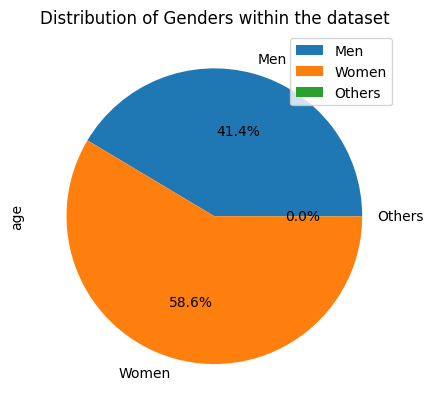

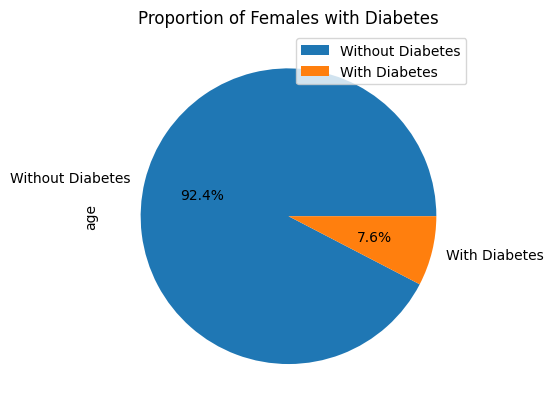

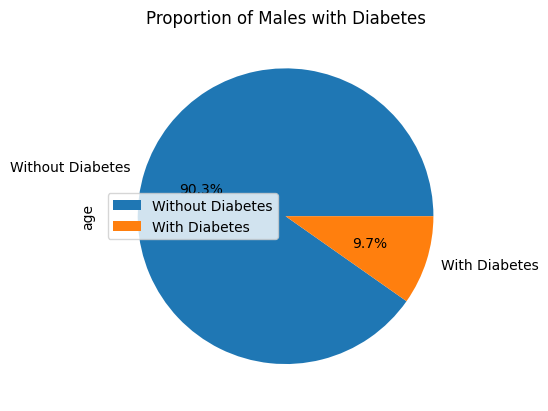

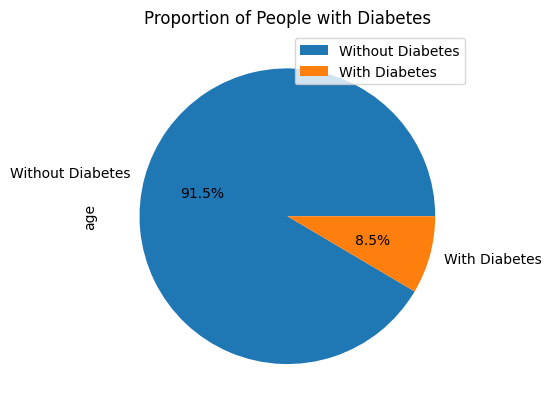

In [23]:
gender_labels = ["Men", "Women", "Others"]
diabetic_labels = ["Without Diabetes", "With Diabetes"]

mf_split = raw_df[["gender", "age"]].groupby("gender").count()
mf_split.plot.pie(y="age", autopct='%1.1f%%', title="Distribution of Genders within the dataset", labels=gender_labels)

f_split = raw_df[raw_df["gender"] == 1]
f_diabetes_split = f_split[["age", "diabetes"]].groupby("diabetes").count()
f_diabetes_split.plot.pie(y="age", autopct='%1.1f%%', title="Proportion of Females with Diabetes", labels=diabetic_labels)

m_split = raw_df[raw_df["gender"] == 0]
m_diabetes_split = m_split[["age", "diabetes"]].groupby("diabetes").count()
m_diabetes_split.plot.pie(y="age", autopct='%1.1f%%', title="Proportion of Males with Diabetes", labels=diabetic_labels)

diabetes_split = raw_df[["age", "diabetes"]].groupby("diabetes").count()
diabetes_split.plot.pie(y="age", autopct='%1.1f%%', title="Proportion of People with Diabetes", labels=diabetic_labels)

- Comparison of mean blood glucose levels against age for each gender
  - The mean blood glucose of men and women across their lives is approximately the same with the most variation at the infant stages
  - Blood Glucose levels increase with age. This may be skewed by the number of older people who present as diabetic.
  - Given the lack of data within the "Others" category, there is significant variation in blood glucose levels. A line of best fit across this data would approximately align with the trend of the male and female levels.
- Comparison of mean blood glucose levels against age, grouped by diabetes diagnosis
  - As observed in the pivot table, diabetes sufferers typically have a higher blood glucose level than non-sufferers
  - There is a large amount of variation in this value at younger ages
  - The trend of the non-sufferers levels is near horizontal with minor variations, unlike the trend for those with diabetes where the mean varies a lot between ages.

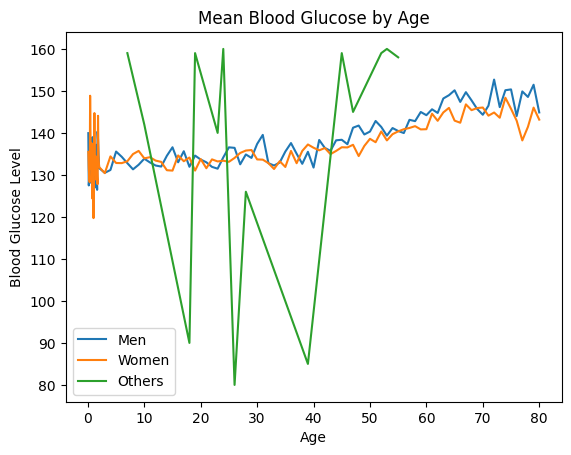

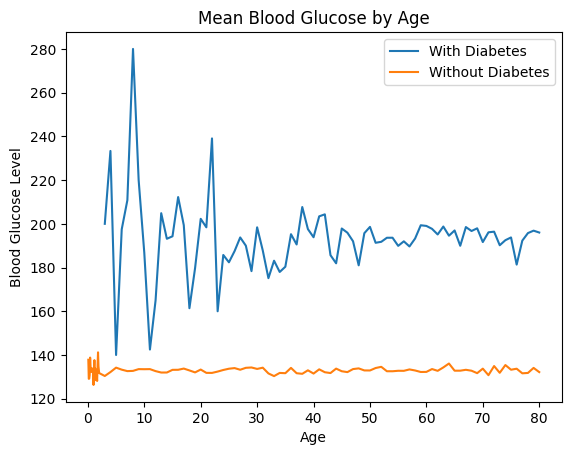

In [24]:
# Line chart of Age against blood Glucose
#Men/Women
o_split = raw_df[raw_df["gender"] == 2]

m_glucose_split = m_split[["age", "blood_glucose_level"]].groupby("age").mean().reset_index()
f_glucose_split = f_split[["age", "blood_glucose_level"]].groupby("age").mean().reset_index()
o_glucose_split = o_split[["age", "blood_glucose_level"]].groupby("age").mean().reset_index()

plt.plot(m_glucose_split["age"], m_glucose_split["blood_glucose_level"], label="Men")
plt.plot(f_glucose_split["age"], f_glucose_split["blood_glucose_level"], label="Women")
plt.plot(o_glucose_split["age"], o_glucose_split["blood_glucose_level"], label="Others")
plt.title("Mean Blood Glucose by Age")
plt.xlabel("Age")
plt.ylabel("Blood Glucose Level")
plt.legend()
plt.show()
#Diabetes or no

diabetes_split = raw_df[raw_df["diabetes"] == 1]
no_diabetes_split = raw_df[raw_df["diabetes"] == 0]

diabetes_glucose_grouped = diabetes_split[["age", "blood_glucose_level"]].groupby("age").mean().reset_index()
no_diabetes_glucose_grouped = no_diabetes_split[["age", "blood_glucose_level"]].groupby("age").mean().reset_index()

plt.plot(diabetes_glucose_grouped["age"], diabetes_glucose_grouped["blood_glucose_level"], label="With Diabetes")
plt.plot(no_diabetes_glucose_grouped["age"], no_diabetes_glucose_grouped["blood_glucose_level"], label="Without Diabetes")
plt.title("Mean Blood Glucose by Age")
plt.xlabel("Age")
plt.ylabel("Blood Glucose Level")
plt.legend()
plt.show()

- Comparison of mean HbA1c levels against age for each gender
  - A similar upwards trend was seen as with the blood glucose levels
  - Male and female levels are near identical across all ages
  - The most variation occurs as infants
- Comparison of mean HbA1c levels against age, grouped by diabetes diagnosis
  - As with Blood Glucose levels, HbA1c in diabetics is higher across all age groups than for non-diabetics
    - This was expected based on the data shown in the initial pivot table
  - There is higher variation of HbA1c values than was the case with blood glucose levels

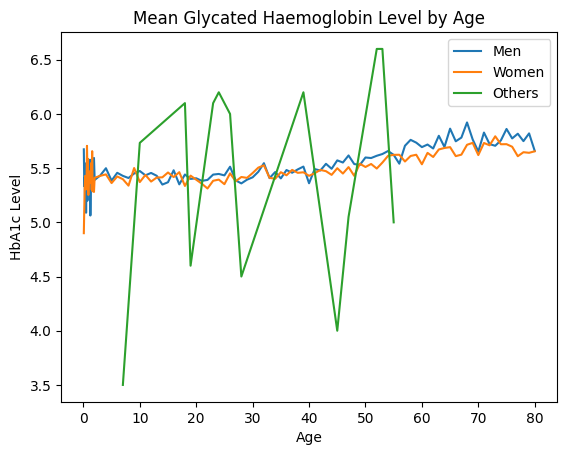

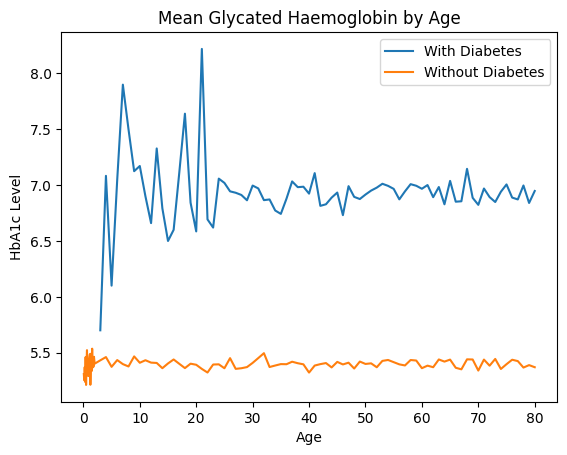

In [25]:
# Line chart of Age against blood Glucose
#Men/Women
m_HbA1c_split = m_split[["age", "HbA1c_level"]].groupby("age").mean().reset_index()
f_HbA1c_split = f_split[["age", "HbA1c_level"]].groupby("age").mean().reset_index()
o_HbA1c_split = o_split[["age", "HbA1c_level"]].groupby("age").mean().reset_index()

plt.plot(m_HbA1c_split["age"], m_HbA1c_split["HbA1c_level"], label="Men")
plt.plot(f_HbA1c_split["age"], f_HbA1c_split["HbA1c_level"], label="Women")
plt.plot(o_HbA1c_split["age"], o_HbA1c_split["HbA1c_level"], label="Others")
plt.title("Mean Glycated Haemoglobin Level by Age")
plt.xlabel("Age")
plt.ylabel("HbA1c Level")
plt.legend()
plt.show()
# Diabetes or no

diabetes_HbA1c_grouped = diabetes_split[["age", "HbA1c_level"]].groupby("age").mean().reset_index()
no_diabetes_HbA1c_grouped = no_diabetes_split[["age", "HbA1c_level"]].groupby("age").mean().reset_index()

plt.plot(diabetes_HbA1c_grouped["age"], diabetes_HbA1c_grouped["HbA1c_level"], label="With Diabetes")
plt.plot(no_diabetes_HbA1c_grouped["age"], no_diabetes_HbA1c_grouped["HbA1c_level"], label="Without Diabetes")
plt.title("Mean Glycated Haemoglobin by Age")
plt.xlabel("Age")
plt.ylabel("HbA1c Level")
plt.legend()
plt.show()

- HbA1c and Glucose levels were plotted against each other given their similar trends, producing the grid pattern below
  - 2 distinct clusters can be seen, 1 for diabetics and 1 for non-diabetics with overall higher readings for the diabetics
  - There is considerable overlap between the measured results, suggesting a large area for potential false classifications

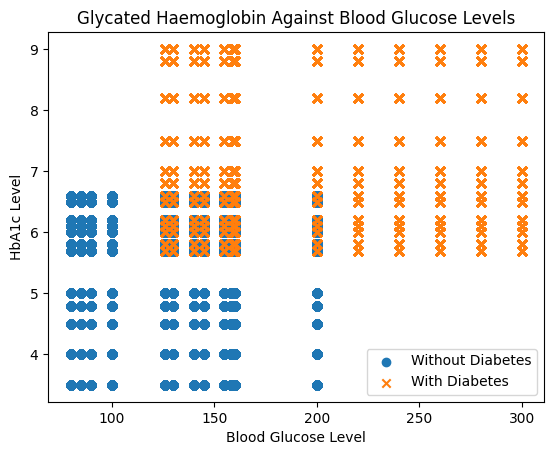

In [26]:
plt.scatter(no_diabetes_split["blood_glucose_level"], no_diabetes_split["HbA1c_level"], label="Without Diabetes")
plt.scatter(diabetes_split["blood_glucose_level"], diabetes_split["HbA1c_level"], label="With Diabetes", marker="x")
plt.title("Glycated Haemoglobin Against Blood Glucose Levels")
plt.xlabel("Blood Glucose Level")
plt.ylabel("HbA1c Level")
plt.legend()
plt.show()

- Box Plot of BMI, group by diabetes diagnosis
  - Highest and lowest BMIs within the dataset are both within the non-diabetic group
  - Wider range of BMIs within the IQR of the diabetic group
  - Approximately similar median BMI values between groups
  - Indicative that a higher BMI may not be a significant factor in diagnosing diabetes

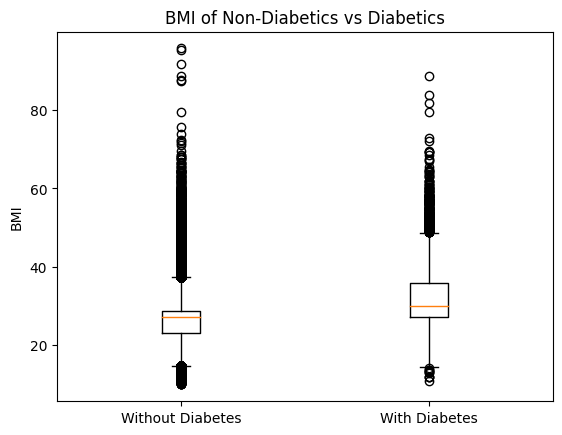

In [27]:
bmi_data = [no_diabetes_split["bmi"], diabetes_split["bmi"]]
plt.boxplot(bmi_data, labels=["Without Diabetes", "With Diabetes"])
plt.title("BMI of Non-Diabetics vs Diabetics")
plt.ylabel("BMI")
plt.show()

- Pie charts showing the distribution of smoking history responses across the whole dataset and specifically diabetics
  - 40% of the dataset returned "No Info", compared with 23% of diabetics
  - 35% of the whole dataset have never smoked, compared with 40% of diabetics
  - A higher number of diabetics has stopped smoking at 27%, compared with 16% of the whole sample
  - The diabetics group also has a higher proportion of active smokers than the whole dataset

<Axes: title={'center': 'Smoking History of Diabetics within the dataset'}, ylabel='age'>

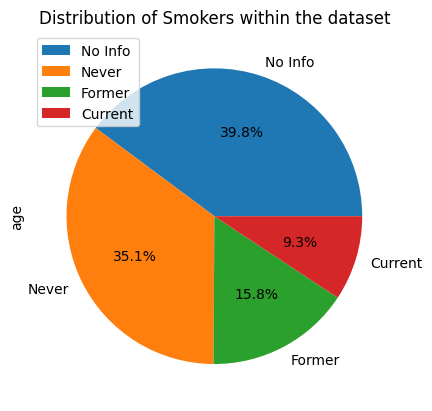

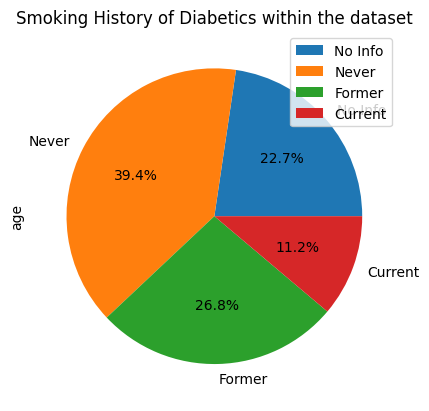

In [28]:
smoking_labels = ["No Info", "Never", "Former", "Current"]

mf_split = raw_df[["smoking_history", "age"]].groupby("smoking_history").count()
mf_split.plot.pie(y="age", autopct='%1.1f%%', title="Distribution of Smokers within the dataset", labels=smoking_labels)

diabetic_smoker_split = diabetes_split[["smoking_history", "age"]].groupby("smoking_history").count()
diabetic_smoker_split.plot.pie(y="age", autopct='%1.1f%%', title="Smoking History of Diabetics within the dataset", labels=smoking_labels)

- Pie Charts showing the proportion of the dataset and those diagnosed with diabetes who show as Hypertensive
  - A significantly higher proportion of diabetics present as hypertensive, than those without a diagnosis

<Axes: title={'center': 'Hypertensive Diabetics within the dataset'}, ylabel='age'>

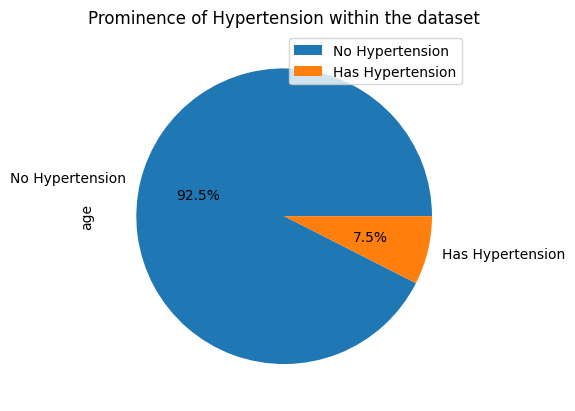

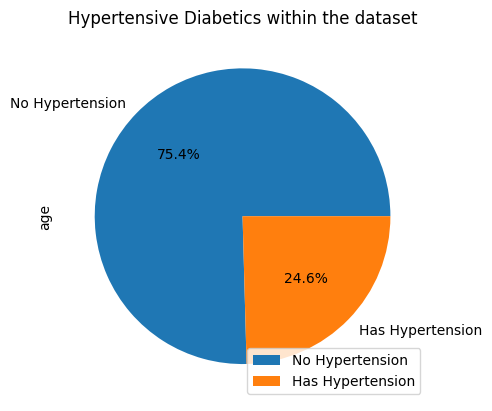

In [29]:
hypertensive_labels = ["No Hypertension", "Has Hypertension"]

mf_split = raw_df[["hypertension", "age"]].groupby("hypertension").count()
mf_split.plot.pie(y="age", autopct='%1.1f%%', title="Prominence of Hypertension within the dataset", labels=hypertensive_labels)

diabetic_smoker_split = diabetes_split[["hypertension", "age"]].groupby("hypertension").count()
diabetic_smoker_split.plot.pie(y="age", autopct='%1.1f%%', title="Hypertensive Diabetics within the dataset", labels=hypertensive_labels)

- Pie Charts showing the proportion of the dataset and those diagnosed with diabetes with a history of Heart Disease
  - A significantly higher proportion of diabetics have heart disease than those without a diagnosis

<Axes: title={'center': 'Diabetics with Heart Disease within the dataset'}, ylabel='age'>

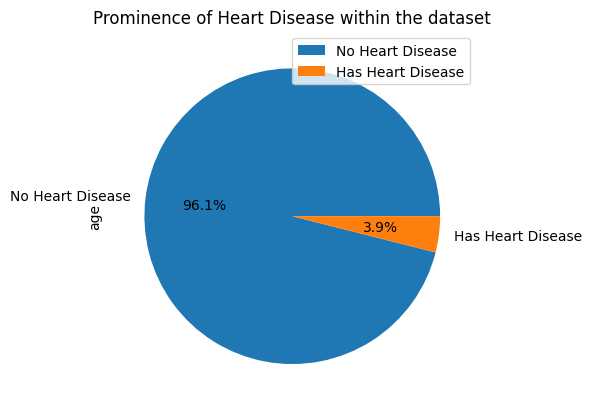

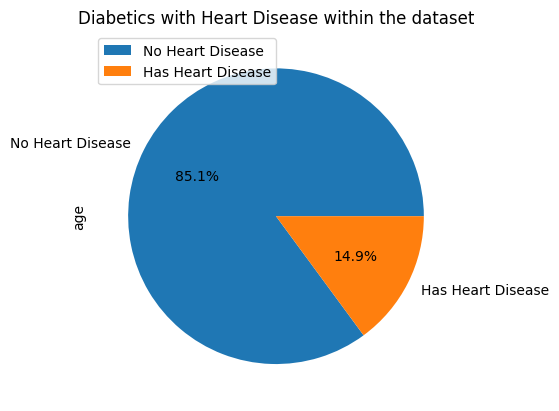

In [30]:
heart_disease_labels = ["No Heart Disease", "Has Heart Disease"]

mf_split = raw_df[["heart_disease", "age"]].groupby("heart_disease").count()
mf_split.plot.pie(y="age", autopct='%1.1f%%', title="Prominence of Heart Disease within the dataset", labels=heart_disease_labels)

diabetic_smoker_split = diabetes_split[["heart_disease", "age"]].groupby("heart_disease").count()
diabetic_smoker_split.plot.pie(y="age", autopct='%1.1f%%', title="Diabetics with Heart Disease within the dataset", labels=heart_disease_labels)

#### Visualisation Summary
From the pivot table, charts and graphs above, it can be seen that though features such as BMI may be considered by doctors as key factors when diagnosing diabetes, they are not as significant when compared with the blood glucose and HbA1c levels which provide a clearer indication of diabetes or not. Additionally, other risk factors such as smoking history, hypertension and heart disease can be seen in the data as being more prominent in diabetics, however not present in the majority of participants, supporting a diagnosis but in themselves not being a significant factor.

### Selection of Machine Learning Models to use
Based on the data visualised above, the use of a supervised learning models such as Random Forest would be best suited to diagnosing this type of problem. This type of model has been chosen as the data has a significant amount of overlap between data in each category, this being appearing too complex for clustering algorithms. Prediction models such as regression are also unsuitable in this project, given the classification nature of the task. Feature importance can also be conducted on classifier models to identify which of the supplied features impacts an entries classification the most.

The biggest challenge that will be faced by the selected model will be minimising the quantity of false negative classifications that are given as these are the most potentially harmful to patients as this could lead to more severe symptoms presenting themselves and permanent damage to the patient's body. Contrary to this, a false positive diagnosis will in most cases receive [diet-control advice](https://www.nhs.uk/conditions/type-2-diabetes/food-and-keeping-active/) from the diagnosing doctor instead of strong medications, as these are likely to occur on edge cases where the overlap between diabetic and not exists. Though technically a false diagnosis, this can be more accepted by the model as there will be no long-term implications to the patient in these cases.

For this project, a Random Forest and Support Vector Machine classification model were implemented, being validated against each other.

#### Random Forest Ensemble Implementation
Random Forest classifiers implement ensemble methods to determine the classification of an item. This uses more processing power to compute than other methods but has been shown to provide more accurate classifications and reduce the affects of data over-fitting. The forest for this project was made up of 750 decision trees with low correlation, being trained on the training 50% of the dataset.

Before the model's performance was evaluated, permutation importance was conducted. This was chosen over other feature importance assessments using mean decrease in impurity as it is less susceptible to biases caused by high-cardinality. The data used while computing the feature importance using this method also shuffles a number of times (5 in this model) to improve the accuracy of the importance calculation.

As can be seen in the 1st graph below, the importances for blood glucose and HbA1c levels are significantly higher than those for the other features. This was expected based on the initial visualisations that were made. Another plot of the importances was made using a logarithmic scale on the y-axis such that these values could be seen more clearly. The least important features identified by this model were the patient's gender and smoking history, while BMI and age contributed the most after the glucose and haemoglobin levels were considered.

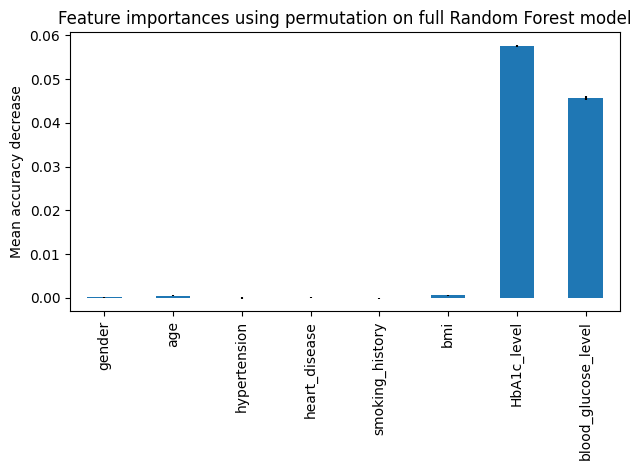

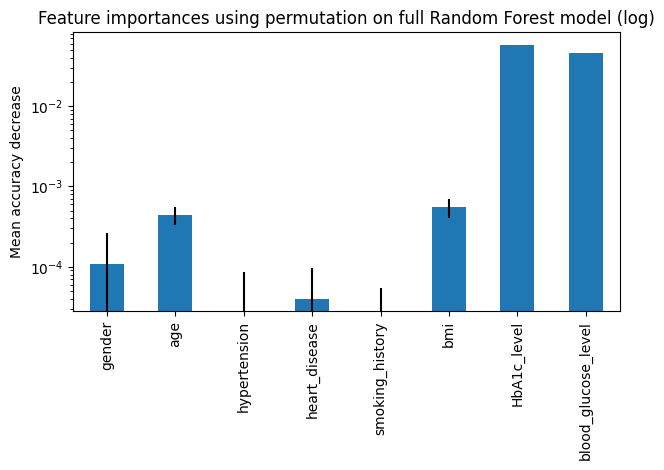

HbA1c_level            0.057628
blood_glucose_level    0.045704
bmi                    0.000548
age                    0.000444
gender                 0.000108
heart_disease          0.000040
hypertension          -0.000048
smoking_history       -0.000084
dtype: float64


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

forest = RandomForestClassifier(n_estimators=750)
forest.fit(train_features, train_labels)

rf_perm_importance = permutation_importance(forest, test_features, test_labels, n_repeats=5, n_jobs=-1)

rf_importances = pd.Series(rf_perm_importance.importances_mean, index=feature_names)

rf_importances.plot.bar(yerr=rf_perm_importance.importances_std)
plt.title("Feature importances using permutation on full Random Forest model")
plt.ylabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()

rf_importances.plot.bar(yerr=rf_perm_importance.importances_std, logy=True)
plt.title("Feature importances using permutation on full Random Forest model (log)")
plt.ylabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()

print(rf_importances.sort_values(ascending=False))

The accuracy of the model was tested using the `score` method. with 750 trees, the resulting model was 97% accurate on the 50,000 test cases that were passed to it. Though a reasonable accuracy, there were still 3% of cases being incorrectly diagnosed.

To identify where these incorrect diagnosis were occurring, a confusion matrix was produced which showed that 0.3% of the incorrect classifications were within the less harmful "False Positive" category while the remaining 2.7% flagged as "False Negative" results. The model was tuned during implementation, testing as many as 2000 decision trees and as few as 100, this forest size achieving the least number of harmful false classifications.

0.97082

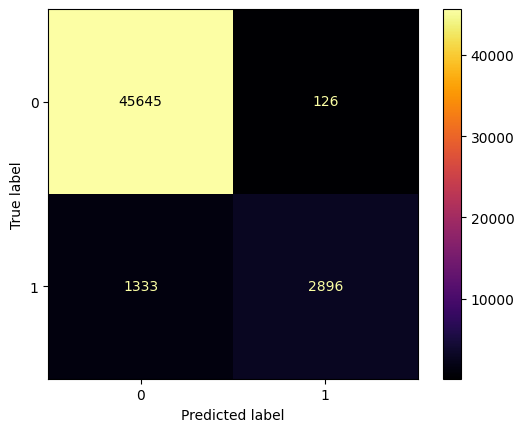

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

rf_cm = ConfusionMatrixDisplay.from_estimator(forest, test_features, test_labels, cmap="inferno")
rf_accuracy = forest.score(test_features, test_labels)
rf_accuracy

#### Support Vector Machine Implementation
A linear Support Vector Machine model was implemented to validate against the Random Forest model. As with Random Forest, a permutation importance was run to identify the features that most impact the classification returned by the model. The overall accuracy and a breakdown of the returned classifications as a confusion matrix were also done.

The HbA1c and glucose levels were identified as the most important features by this model, as with Random Forest, however, age and BMI were given more weight. As before, a graph of the importances using a logarithmic scale on the y-axis was used such that the data was more readable. When comparing the charts from each model, only minor differences in importance exist between all but the glucose and HbA1c levels, resulting in different orders for the remaining features when sorted from most to least importance. Heart Disease is the best example of this difference, being seen as the 2nd least important by SVM but 5th most important by the Random FOrest.

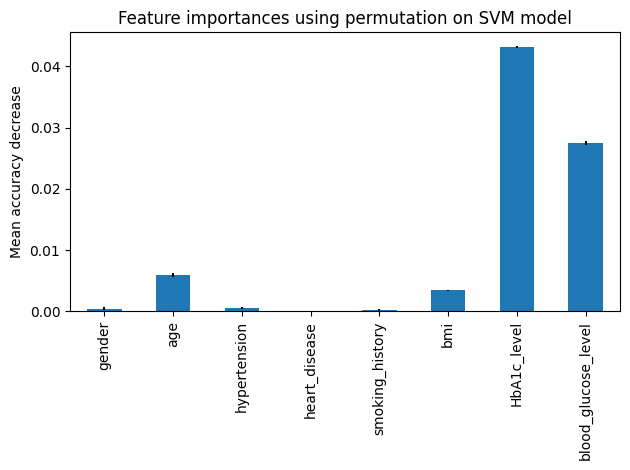

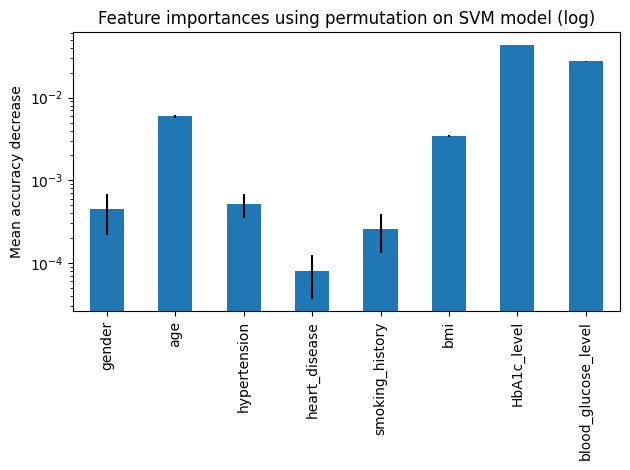

HbA1c_level            0.043193
blood_glucose_level    0.027460
age                    0.005920
bmi                    0.003447
hypertension           0.000520
gender                 0.000453
smoking_history        0.000260
heart_disease          0.000080
dtype: float64


In [33]:
from sklearn.svm import SVC

svm = SVC(kernel="linear")
svm.fit(train_features, train_labels)

svm_perm_importance = permutation_importance(svm, test_features, test_labels, n_repeats=3, n_jobs=-1)

svm_importances = pd.Series(svm_perm_importance.importances_mean, index=feature_names)

svm_importances.plot.bar(yerr=svm_perm_importance.importances_std)
plt.title("Feature importances using permutation on SVM model")
plt.ylabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()

svm_importances.plot.bar(yerr=svm_perm_importance.importances_std, logy=True)
plt.title("Feature importances using permutation on SVM model (log)")
plt.ylabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()

print(svm_importances.sort_values(ascending=False))

The SVM model also results in a 96% accuracy, being 1% less accurate than the Random Forest model. The majority of these inaccuracies resulted in false negative diagnosis which were identified as being the most harmful of the incorrect classifications.

0.9602

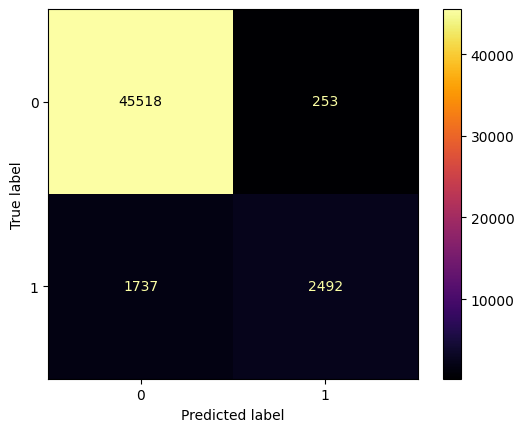

In [34]:
svm_cm = ConfusionMatrixDisplay.from_estimator(svm, test_features, test_labels, cmap="inferno")
svm_accuracy = svm.score(test_features, test_labels)
svm_accuracy

## Determining Type 1 and Type 2 Diabetes
An additional objective within this project was to explore the potential uses of feature engineering on the dataset to see if a distinction between Type 1 and Type 2 diabetes could be made and if so, could this further aid GP's in providing more information to patients. Given the lack of labels existing within the dataset relating to these classifications, a clustering algorithm would be best suited to producing a new feature that could be used with the dataset. KMeans was selected for this, determining 2 clusters from the data.

In order to cluster the data, the data about all diabetics within the training dataset was 1st extracted. For this to work however, the features and labels dataframes needed to be merged as the diabetes label had been separated from the training data. This was done using the `merge` method where index values were matched to ensure the correct diabetes classification was attached to the relevant features.

Once the KMeans model was trained on the data from all diabetics within the training set, a graph of blood glucose against HbA1c levels was plotted using the clusters that were identified. In the chart, the centroids of the 2 clusters can be seen in green, with a very large entropy value. It was decided that these clusters weren't usable as they assume a 50/50 split between the 2 classifications which is not representative of the real distribution of diabetes types with [over 90% of UK diabetics being diagnosed as Type 2](https://www.diabetes.org.uk/professionals/position-statements-reports/statistics)

The decision to stop pursuing the diagnosis of specific diabetes types using this dataset was further motivated by information from [diabetes.org.uk](https://www.diabetes.org.uk/professionals/position-statements-reports/diagnosis-ongoing-management-monitoring/new_diagnostic_criteria_for_diabetes) which states that HbA1c and Blood Glucose alone as tests are unsuitable for determining types. Other features within the dataset are also unable to aid in the diagnosis of these. Ideally, a Glucose Tolerance Test would be conducted on a patient for Type 1 diabetes to be diagnosed.

KMeans Model Inertia: 3650505.6193345413


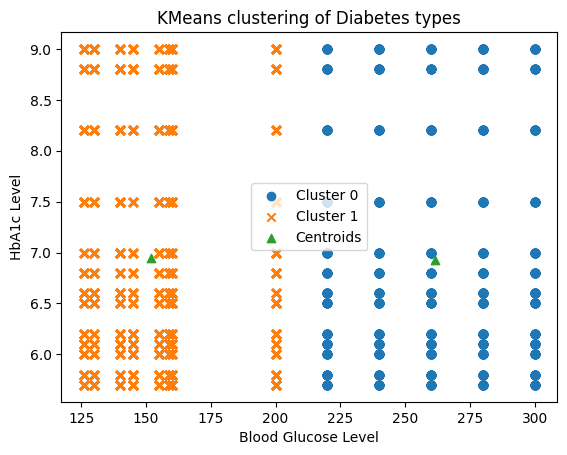

In [35]:
from sklearn.cluster import KMeans
import copy

training_data_join = pd.merge(train_features, train_labels, left_index=True, right_index=True)
temp_data = training_data_join[training_data_join["diabetes"] == 1]
diabetes_cluster_train = copy.copy(temp_data)

km = KMeans(n_clusters=2, n_init=10, max_iter=1000)
diabetes_cluster_train["diabetes_type"] = km.fit_predict(diabetes_cluster_train)

type0_diabetes = diabetes_cluster_train[diabetes_cluster_train["diabetes_type"] == 0]
type1_diabetes = diabetes_cluster_train[diabetes_cluster_train["diabetes_type"] == 1]
centroids = km.cluster_centers_
print(f"KMeans Model Inertia: {km.inertia_}")

plt.scatter(type0_diabetes["blood_glucose_level"], type0_diabetes["HbA1c_level"], label="Cluster 0")
plt.scatter(type1_diabetes["blood_glucose_level"], type1_diabetes["HbA1c_level"], label="Cluster 1", marker="x")
plt.scatter(centroids[:,7], centroids[:,6], label="Centroids", marker="^")

plt.title("KMeans clustering of Diabetes types")
plt.xlabel("Blood Glucose Level")
plt.ylabel("HbA1c Level")
plt.legend()
plt.show()

### Project Summary
Of the objectives set at the beginning of the project, the identification of which features are most significant and the implementation of ensemble classification were both met. Determining Type 1 vs Type 2 diabetes from the dataset was also explored, however, it was determined that this was not possible given the available data.

Both of the classification models that were trained on this dataset determined that the blood glucose level and HbA1c level were the most significant factors when determining whether a patient has diabetes or not. This is likely because both of these values are used very heavily by doctors to diagnose diabetes, having pre-defined boundaries for what would be classed as diabetic in each case.

Random Forest was chosen as the ensemble classification model for this project. When compared to the linear SVM that was also implemented, it performed better, being 1% more accurate and classifying significantly fewer false negative results. The model itself achieved 97% accuracy overall. It is assumed that the majority of the false negative classifications occurred in the region of overlap between those who have diagnosed diabetes and those without. From this, there is potential that some patients may be pre-diabetes or be undiagnosed at the time when the data was collected which skewed the training data. Unfortunately, little additional information within the [kaggle page for this dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) was present that can be used to substantiate this assumption.

Overall, though the models developed could be useful by doctors for the diagnosis of diabetes, they are not accurate enough for use within the medical field where the outputs could have serious impact on a patient's life. These inaccuracies could be mitigated by providing more information such as the results of a glucose tolerance test which would not only allow for more accurate diabetes diagnosis but also support the identification of different types of diabetes.